# Classification and Regression Trees (CART) ---- Cost-Complexity Pruning ---- Bagging.

In this notebook we will explore and implement the theory of regression and decisions trees. Our goal is to implement from scratch this common ML algorithm, leading all the way up to a simple implementation of a Random Forest classifier. The primary resource for this notebook is ESL by Hastie, Tibshirani and Friedman.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## (I) CART

For the first part of this project, we will implement a simple regression and classification tree.  Hence we create two synthetic datasets for the respective case. 

For the regression case, we will use 1D data as generated in https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html#sphx-glr-auto-examples-tree-plot-tree-regression-py.

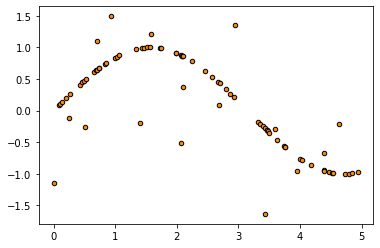

In [ ]:
# Import synthetic data for regression
rng = np.random.RandomState(1)
X_reg = np.sort(5 * rng.rand(80, 1), axis=0)
y_reg = np.sin(X_reg).ravel()
y_reg[::5] += 3 * (0.5 - rng.rand(16))

plt.figure()
plt.scatter(X_reg, y_reg, s=20, edgecolor="black",
            c="darkorange", label="data")
plt.show()

For the classification case, we will generate 2D synthetic data 

In [ ]:
def simulateData(nPoints, errorRate):
    '''
    Create simulated data in unit square. Points with x + y > 1 are in class 1 and otherwise is class
    0. However, a certain random portion of the points have their classes randomly switched, the 
    proportion indicated by the error rate.

    Parameters
    ----------
    nPoints : Int
        The number of points in the simulated data.
    
    errorRate : Float
        The proportion of the data that will be randomly selected to have their classes flipped.

    Returns
    -------
    Numpy Array of Float of Shape (nPoints, 2)
        The xy-coordinates of the data.
    
    Numpy Array of Int of Shape (nPoints, 1)
        The classes of each data point.
    '''

    x = np.random.rand(nPoints, 2)

    y = np.zeros(nPoints)
    upperRight = x[:, 0] + x[:, 1] > 1
    y[upperRight] = 1

    errors = np.random.choice(np.arange(nPoints), int(nPoints * errorRate))
    y[errors] = 1 - y[errors] 

    return x, y.reshape(-1, 1)

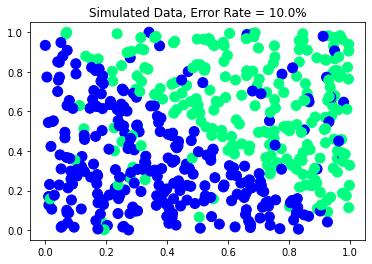

In [ ]:
nPoints = 500
errorRate = 0.1
X_cla, y_cla = simulateData(nPoints, errorRate)

# Graph the data.

plt.scatter(X_cla[:, 0], X_cla[:, 1], c = y_cla, cmap = 'winter', s = 100)
plt.title('Simulated Data, Error Rate = ' + str(errorRate * 100) + "%")
plt.show()

### Let us briefly recap some of the theory behind CART.

Regression Tree:

We are given N observations $(x_i, y_i)$ with $x$ of dimension $p$. We want to partition into $M$ regions $R_1, \ldots, R_M$ and model the response as a constant $c_m$ in each region:

> $f(x) = \sum_{m=1}^M c_m I(x \in R_m)$

Now finding the best partition to minimise sum of squares $\sum (y_i - f(x_i))$ is computationally infeasible. Instead a greedy algorithm is used. We define a splitting variable $j$ and splitting point $s$, and define the half-planes

> $R_1(j,s) = \{X \mid X_j \leq s \} \text{    and    } R_2(j,s) = \{X \mid X_j > s \}$

We wish to find the best dimension (variable $j$) and value (variable $s$) over which to create a binary partition of then data. Hence we wish to find $j, s$ to minimise:

> $\min_{j,s} \left[ \min_{c_1} \sum_{x_i \in R_1(j,s) } (y_i - c_1)^2 + \min_{c_2} \sum_{x_i \in R_2(j,s) } (y_i - c_2)^2 \right]$.

The best $c_1, c_2$ for any $j, s$ is clearly $c_1 = \text{ave}(y_i \mid x_i \in R_1(j,s)), c_2 = \text{ave}(y_i \mid x_i \in R_2(j,s))$. Hence to solve the minimisation we enumerate all possible splits for each value of $j$ and $s$.

After finding the best split, we simply repeat this procedure recursively by solving the same minimisation within the two sub-regions just created. We can choose to grow this tree until a maximum depth is reached or a minimum number of samples per node.


Now we proceed with our implementation:

The data structure used to represent a decision tree is a *binary tree*. For a binary tree we will require a class to represent nodes, each of which represents a single *decision stump*. 

In [ ]:
class Node:
  """
  Class for representing a decision stump. 

  Attributes
  ----------
    data: holds the value c_m that f(x) takes in region R_m
    decision_split: holds the information to make a decision
            i.e. decision_split = (splitting_value, splitting_variable)
                 to represent R_1(j,s) and R_2(j,s) 
    left: points to left child. 
    right: points to right child.
  """
  def __init__(self):
    # Use the value -1 for both child nodes to represent a region node (i.e. both children are leafs)
    self.left = -1
    self.right = -1
    self.data = None
    self.decision_split = None
    self.leaf = False

    # Impurity of node
    self.impurity = 0

    # How many samples are assigned to this node 
    self.num_samples = 0

    # Index variable to uniquely identify node (useful for converting tree to array representation)
    self.index = -1

  def add_data(self, data):
    self.data = data
  
  def add_children(self):
    """
    Function to add children to current node.
    """
    if self.left is -1:
      self.left = Node()
    if self.right is -1:
      self.right = Node()

We also create a Tree class to store an array representation of a binary tree. This is useful for when we want to perform cost-complexity pruning. The tree simply holds attributes to mimic the tree class in sklearn.tree.

In [ ]:
class Tree:
  """
  Array representation of binary tree, useful for pruner class. Pre-order traversal ordering is implicit in the index of each node.
  This follows the representation used by the sklearn.Tree package.
  
  Attributes
  ----------
    -max_depth
    -children_left: indices of left children nodes
    -children_right: indices of right children nodes
    -impurity: impurity of each node such that impurity[i] = impurity of i'th node
    -n_node_samples: number of samples per node.
  """
  def __init__(self, max_depth):
      self.max_depth = max_depth
      self.children_left = []
      self.children_right = []
      self.impurity = []
      self.n_node_samples = []
      self.num_nodes = 0
      self.decision_split = []
      self.decision_value = []

  def make_array(self):

    self.children_left = np.array(self.children_left)
    self.children_right = np.array(self.children_right)
    self.impurity = np.array(self.impurity)
    self.n_node_samples = np.array(self.n_node_samples)
    self.decision_split = np.array(self.decision_split)
    self.decision_value = np.array(self.decision_value)


Finally, we implement the class to recursively subdivide the input region into $M$ subregions to minimise the squared error in a greedy fashion.

In [ ]:
class RegressionTree:
    """
    Class to perform the Regression Tree Algorithm

    Parameters
    ---------
      (X, y): training data with X.shape = (n_points, n_dims) 
      max_depth: the maximum depth of tree
    """
    def __init__(self, max_depth):
        
        self.n_points, self.n_dims = None, None
        self.root = None
        self.max_depth = max_depth
        # Initialise an array representation of the tree.
        self.tree = Tree(max_depth)
        # Counter to count the number of nodes visited and label them accordingly.
        self.counter = -1

    def get_root(self):
      return self.root

    def split_region(self, X, y, n_dims, n_points):
        """
        Split X points into two regions R_1 and R_2 to minimise the sum of square error as given in pg.307 of ESL.

        Returns
        -------
          - min_splitting_variable: the dimension s over which we split the X values
          - min_arr_inds - indices to sort the X values (in the min_splitting_variable dimension) in ascending order
          - min_splitting_point - the index j so that R_1 <= X[j] and R_2 > X[j]
          - min_splitting_value - the value X[j]
        """
        n_points = len(y)

        min_total = np.inf
        min_splitting_point = 0
        min_splitting_value = 0
        min_splitting_variable = 0
        min_arr_inds = None

        total_sum = np.sum(y)

        for splitting_variable in range(n_dims):
            
            # Sorts data according to values in column 'splitting_variable'
            arr_inds = X[:,splitting_variable].argsort()
            X = X[arr_inds]
            y = y[arr_inds]
            
            left_sum = 0
            right_sum = total_sum

            # Iterate through split points to find optimal split in O(n**2) :/ !
            for j in range(0, n_points-1):

                cur_value = y[j]
                left_sum, right_sum = left_sum + cur_value, right_sum - cur_value
                c_1, c_2 = left_sum/(j+1), right_sum/(n_points - (j+1))
                
                total = 0
                for i in range(n_points):
                    if i <= j:
                        total += (y[i] - c_1)**2
                    else:
                        total += (y[i] - c_2)**2

                if total <= min_total:
                    min_total = total
                    min_splitting_point = j
                    
                    # min_splitting_value should be X[j][splitting_variable], but as in sklearn.tree.DecisionTreeRegressor we "interpolate" between X[j] and X[j+1]
                    min_splitting_value = (X[j][splitting_variable] + X[j+1][splitting_variable])/2
                    min_splitting_variable = splitting_variable
                    min_arr_inds = arr_inds


        return min_arr_inds, min_splitting_point, min_splitting_value, min_splitting_variable

    def calculate_impurity(self, y):
      """
      Calculate impurity of a node. For regression we just used squared error from mean.

      Parameters
      ----------
      y: subset of (output) data belonging to node, i.e. it is implicit that the y values have x values belonging to the node. 
      """
      return np.mean((y - np.mean(y))**2)


    def grow_tree(self, X, y, max_depth, node, min_size_per_node):
      """
      Recursive algorithm to grow Regression Tree until max depth is reached or a node contains only a single value.
      Pre-order traversal scheme! Visits root, then grow_tree(left), then grow_tree(right).

      Parameters
      ----------
        X, y: training data/labels
        node: the current node in recursive binary tree
        min_size_per_node: the minimum allowable train samples per node.

      Returns
      -------
          - node: if algorithm reaches bottom of recursive tree (stopping condition) grow_tree returns a None object
                  this sets the pointers to the left and right children of final decision stump to None (i.e. it is a leaf)
      """
      # If node has only one value, it is a leaf (only necessary when we allow min_points = 1).
      node.data = np.mean(y)
      node.impurity = self.calculate_impurity(y)
      node.num_samples = len(y)
      
      if max_depth >= 0 and len(y) >= min_size_per_node:

        self.counter += 1
        node.index = self.counter
        n_dims = X.shape[1]
        n_points = len(y)
          
        min_arr_inds, min_splitting_point, min_splitting_value, min_splitting_variable = self.split_region(X, y, n_dims, n_points)
                
        X_temp, y_temp = X[min_arr_inds], y[min_arr_inds]
        X_left, y_left = X_temp[0:(min_splitting_point+1),:], y_temp[0:(min_splitting_point+1)]
        X_right, y_right = X_temp[(min_splitting_point+1):,:], y_temp[(min_splitting_point+1):]

        l,r = len(y_left), len(y_right)

        # Add child node
        node.add_children()

        # If split incurs node of size less than min_points, do not split
        if l >= min_size_per_node and r >= min_size_per_node:
          
          # node.add_data((min_splitting_value, min_splitting_variable, min_splitting_output, Q_T))
          node.decision_split = (min_splitting_value, min_splitting_variable)
          node.left = self.grow_tree(X_left, y_left, max_depth-1, node.left, min_size_per_node)
          node.right = self.grow_tree(X_right, y_right, max_depth-1, node.right, min_size_per_node)
        else:
          node.left.index = -1
          node.right.index = -1

      else:
        node.index = -1

      return node

    def make_tree(self, root):
      """
      Converts tree to array representation to store in self.tree. This is to have parsimony with the sklearn implementation.
      """
      if root.index is not -1:
        self.tree.num_nodes += 1
        self.tree.impurity.append(root.impurity)
        self.tree.n_node_samples.append(root.num_samples)
        self.tree.value = 0
        self.tree.children_left.append(root.left.index)
        self.tree.children_right.append(root.right.index)
        self.tree.decision_split.append(root.decision_split)
        self.tree.decision_value.append(root.data)
        self.make_tree(root.left)
        self.make_tree(root.right)

    def fit(self, X, y, min_size_per_node=1):
      """
      Function to fit a regression tree with depth = max_depth
      """
      self.root = Node()
      self.tree = Tree(self.max_depth)
      self.counter = -1
      self.n_points, self.n_dims = X.shape[0], X.shape[1]
      self.grow_tree(X, y, self.max_depth, self.root, min_size_per_node)
      # Convert tree representation to array.
      self.make_tree(self.root)
      # Turn this tree into np array.
      self.tree.make_array()
      return self.root

    def predict(self, X):
      """
      Traverse the regression tree F and predict a value F(x) = y
      """

      n_points = X.shape[0]
      output = np.zeros(n_points)

      for i in range(n_points):

        node_i = 0
        X_val = X[i]

        val = self.tree.decision_value[node_i]
      
        while self.tree.children_left[node_i] != -1:

          split_value, split_variable = self.tree.decision_split[node_i]

          if X_val[split_variable] <= split_value:
            node_i = self.tree.children_left[node_i]
          else:
            node_i = self.tree.children_right[node_i]

          val = self.tree.decision_value[node_i]
        
        output[i] = val

      return output

We proceed to fit our regression tree to the synthetic data. Ther results are compared to the sklean.tree.DecisionTreeRegressor to check for correctness.

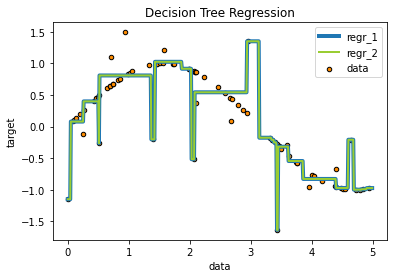

In [ ]:
# Fit our regression tree
regr_1 = RegressionTree(max_depth=5)
regr_1.fit(X_reg, y_reg, min_size_per_node=1)

# Compare with sklearn 
from sklearn.tree import DecisionTreeRegressor
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_2.fit(X_reg, y_reg)

# Predict values and plot the decision boundaries
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

# Plot the results
plt.figure()
plt.scatter(X_reg, y_reg, s=20, edgecolor="black",
            c="darkorange", label="data")
plt.plot(X_test, y_1, label="regr_1", linewidth=4)
plt.plot(X_test, y_2, color="yellowgreen", label="regr_2", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

The region divisions perfectly overlap, and so it appears the implementation is correct (we still need to test for higher dimensional settings). However the regression tree has *overfit* - it is changing its prediction wildly for just a single data point. We can mitigate this effect using **cost-complexity pruning**. Let: \\
$N_m = |\{x_i \in R_m \}|$ \\
$c_m = \frac{1}{N_m} \sum_{x_i \in R_m} y_i$ \\
$Q_m(T) = \frac{1}{N_m} \sum_{x_i \in R_m} (y_i - c_m)^2$ \\
then define the cost complexity criterion as: \\
$C_{\alpha}(T) = \sum_{m=1}^{|T|}N_m Q_m(T) + \alpha |T|$ \\

As noted in ESL, we want to find the subtree $T_\alpha 	\subseteq T$ that minimises $C_\alpha(T)$. To do so we perform *weakest link pruning*. We collapse the internal nodes which would produce the smallest increase in $\sum_m N_m Q_m(T)$ (i.e. we merge two regions together, choosing the two regions which would minimise the difference in impurity). \\
This gives a sequence of subtrees (which must contain $T_\alpha$ - no proof here). Following this we cross validate to find the optimal alpha.

https://matthewmcgonagle.github.io/blog/2018/09/13/PruningDecisionTree

We first create a class to prune the tree. It takes as input the DecisionTree.tree array representation of the decision tree. The tree follows the representation as used in sklearn. Specifically, nodes are labelled from 0 (root) node to N (for N nodes). Leaf nodes are labelled with -1. The arrays at index i: tree.children_left[i], and tree.children_right[i] hold the indices of the children to node i. 

Additionally, the array tree.impurity at index i holds the impurity of the i'th node. The array tree.n_node_samples at index i holds the number of samples of the i'th node.

In [ ]:
class Pruner:
  """
  Class to perform pruning on a Decision Tree (regression or classification)  
  """

  def __init__(self, tree):

    self.tree = tree
    self.leaves = self.get_leaves(tree)
    self.parents = self.get_parents(tree)
    self.prune_costs = self.get_prune_costs(tree)

    # Store original tree and total cost
    self.original_children = list(zip(tree.children_left.copy(), tree.children_right.copy()))
    self.total_cost = np.sum(self.prune_costs[self.leaves])
    
    self.pruned = np.full(len(tree.impurity), False)
    self.pruned[self.leaves] = True

    self.prune_order, self.cost_order = self.find_prune_order(tree)
  
    # how many splits have been pruned
    self.prune_state = 0

  def get_leaves(self, tree):
    """
    Get the indices of the leaf nodes, i.e. nodes whose two children have index -1.
    """
    leaves = []
    for node_i, left_child in enumerate(tree.children_left):
      # Children always come in pairs
      if left_child == -1:
        leaves.append(node_i)

    return leaves

  def get_parents(self, tree):
    """
    Get the index of the parent node for each child node
    """
    parents = np.full(len(tree.children_left), -1) 

    for node_i, (left_child, right_child) in enumerate(zip(tree.children_left, tree.children_right)):

        if left_child != -1:
            parents[left_child] = node_i
            parents[right_child] = node_i

    return parents

  def get_prune_costs(self, tree):
    """
    Function to get the pruning costs of all internal nodes - cost associated with collapsing every internal node. E.g if a parent node represents regions R_{1+2}, and
    its child nodes represent the split R_{1} and R_{2}, the the cost is given by the difference between 
    the internal node impurity (new cost / R_{1+2}) and the impurity of its two child nodes (old cost / R_{1} + R_{2})
    """
    prune_costs = np.zeros(len(tree.impurity))
    node_costs = tree.n_node_samples*tree.impurity

    for node_i, (left_child, right_child) in enumerate(zip(tree.children_left, tree.children_right)):

      if left_child != -1:
        cur_cost = node_costs[node_i] - node_costs[left_child] - node_costs[right_child]
        prune_costs[node_i] = cur_cost
    
    return prune_costs

  def get_prune_candidates(self, tree):
    """
    Function to get all pruning candidate nodes and their pruning costs.
    """
    candidates = []
    candidate_costs = []

    for leaf_index in self.leaves:
      
      parent_index = self.parents[leaf_index]

      if parent_index != -1:
        left_child = tree.children_left[parent_index]
        right_child = tree.children_right[parent_index]

        if self.pruned[left_child] and self.pruned[right_child] and parent_index not in candidates:
          candidates.append(parent_index)
          candidate_costs.append(self.prune_costs[parent_index])
    
    return candidates, candidate_costs

  def prune_and_pop(self, candidates, candidate_costs):
    """
    Function to select the candidate split with the minimium cost of pruning. The candidate is then removed from the
    list of candidates, and the associated cost removed from the list of costs.
    """

    min_cost_index = np.argmin(candidate_costs)
    next_candidate = candidates.pop(min_cost_index)
    candidate_costs.pop(min_cost_index)

    return next_candidate

  def find_prune_order(self, tree):
    """
    Function to find the optimal (greedy) pruning order of the tree. I.e. it finds a sequence of subtrees 
    T_{\alpha} \subseteq T by weakest link pruning.

    Returns
    -------
      prune_order: the order to prune the tree
      cost_order: the associated cost graph 
    """
    prune_order = [-1]
    cost_order = [0]
    current_cost = 0

    candidates, costs = self.get_prune_candidates(tree)

    while candidates:

      prune_index = self.prune_and_pop(candidates, costs)
      self.pruned[prune_index] = True
      prune_order.append(prune_index)
      current_cost += self.prune_costs[prune_index]
      cost_order.append(current_cost)

      parent_index = self.parents[prune_index]

      if parent_index != -1:
        left_child = tree.children_left[parent_index]
        right_child = tree.children_right[parent_index]

        if self.pruned[left_child] and self.pruned[right_child]:
          candidates.append(parent_index)
          costs.append(self.prune_costs[parent_index])

    return np.array(prune_order), np.array(cost_order)

  def prune(self, num_prunes):
    """
    Perform pruning on the tree, given precomputed prune order and cost order.
    Parameters
    ----------
      num_prunes: how many nodes/splits we would like to prune
    """

    max_num_prunes = len(self.prune_order)

    # If num_prunes is negative then use negative array indexing.
    if num_prunes < 0:
      num_prunes += max_num_prunes

    if num_prunes > self.prune_state:

      for node_index in range(self.prune_state+1, num_prunes+1):

        prune_node = self.prune_order[node_index]
        self.tree.children_left[prune_node] = -1
        self.tree.children_right[prune_node] = -1

    # If number of prunes is less than current prune state, we want to restore splits to the tree.
    elif num_prunes < self.prune_state:

      for node_index in range(num_prunes, self.prune_state+1):

        prune_node = self.prune_order[node_index]
        left_child, right_child = self.original_children[prune_node]
        self.tree.children_left[prune_node] = left_child
        self.tree.children_right[prune_node] = right_child
    
    self.prune_state = num_prunes

  def cost_complexity(self, alpha):
    """
    Function to compute the cost-complexity for each subtree T_\{alpha}

    Parameters
    ----------
      alpha: the cost complexity weight term (regularisation parameter for the size of the tree)
    """
    max_num_prunes = len(self.prune_order)
    T = self.tree.num_nodes - 2 * np.arange(0, max_num_prunes)

    cost_complexity = np.full(max_num_prunes, self.total_cost)
    cost_complexity += self.cost_order + alpha*T

    return T, cost_complexity

  def cost_complexity_prune(self, alpha):
    """
    Computes the optimal subtree T_\{alpha} for a given value of alpha, and prunes the tree.
    """
    T, cost_complexity = self.cost_complexity(alpha)
    min_index = np.argmin(cost_complexity)
    self.prune(min_index)

    size, val = T[min_index], cost_complexity[min_index]
    
    return size, val 

The class above is used for pruning the tree for a given value of $\alpha$. However, we wish to find the optimal value of $\alpha$. Hence we require a class to cross validate over the choice of $\alpha$. Defined below is a class for performing cross validation:

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

In [ ]:
def error(y_pred, y_true):
  return np.linalg.norm(y_true - y_pred)

In [ ]:
def cross_validate(model, x, y, num_cross_val, alphas):

  len_alphas = len(alphas)

  df = pd.DataFrame(columns=['complexity weight', 'accuracy', 'tree size'])
  loc = 0

  for _ in range(num_cross_val):

    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8)


    model.fit(x_train, y_train)
    pruner = Pruner(model.tree)

    for alpha in alphas:

      size, val = pruner.cost_complexity_prune(alpha)

      y_pred = model.predict(x_test)
      acc = error(y_pred, y_test)

      df.loc[loc] = [alpha, acc, size]

      loc += 1

  return df

In [ ]:
alphas = np.linspace(0, 10.4, 100)
num_cross_val = 100
df = cross_validate(RegressionTree(max_depth=5), X_reg, y_reg, num_cross_val, alphas)

In [ ]:
df.head()

,complexity weight,accuracy,tree size
0,0.000000,1.487341,43.0
1,0.105051,1.532564,25.0
2,0.210101,1.570626,17.0
3,0.315152,1.570626,17.0
4,0.420202,1.570626,17.0


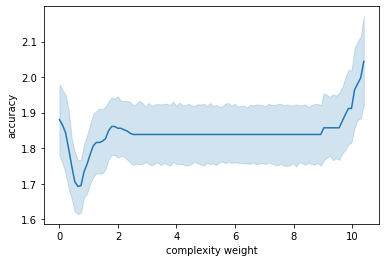

In [ ]:
import seaborn as sns

sns.lineplot(data=df, x="complexity weight", y ="accuracy")